In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import math
import sklearn.metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import copy
import os
import shutil
import urllib.request
import csv
import pandas as pd
from scipy.stats import bootstrap
import statistics
from PIL import Image
import warnings

from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
warnings.filterwarnings("ignore")
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score


from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


### Q1.Time Series Classification Part 1: Feature Creation/Extraction

#### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
source_folder = "../data/AReM"

# Filter out any unwanted directories, like .ipynb_checkpoints
folder_list = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f)) and f != ".ipynb_checkpoints"]

train_dir = "../data/train_data"
test_dir = "../data/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

list_1 = ['dataset1.csv', 'dataset2.csv']
list_2 = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']

# Copy the format of the AReM folder with only empty folders
for folder in folder_list:
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)

# Add files to the test_data folder
for folder in folder_list:
    raw_folder = os.path.join(source_folder, folder)
    test_folder = os.path.join(test_dir, folder)
    files = [f for f in os.listdir(raw_folder) if os.path.isfile(os.path.join(raw_folder, f))]
    
    if len(files) < 8:
        for file in list_1:
            if file in files:  # Ensure file exists before copying
                shutil.copy(os.path.join(raw_folder, file), test_folder)
    else:
        for file in list_2:
            if file in files:  # Ensure file exists before copying
                shutil.copy(os.path.join(raw_folder, file), test_folder)

# Add files to the train_data folder
for folder in folder_list:
    raw_folder = os.path.join(source_folder, folder)
    train_folder = os.path.join(train_dir, folder)
    files = [f for f in os.listdir(raw_folder) if os.path.isfile(os.path.join(raw_folder, f))]
    
    if len(files) < 8:
        for file in files:
            if file not in list_1:
                shutil.copy(os.path.join(raw_folder, file), train_folder)
    else:
        for file in files:
            if file not in list_2:
                shutil.copy(os.path.join(raw_folder, file), train_folder)

In [3]:
col_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
test_base = '../data/test_data/'
train_base = '../data/train_data/'

def file_check(base):
    for folder in folder_list:
        folder_path = os.path.join(base, folder)
        
        # Get only .csv files from the directory
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]
        
        for file in files:
            csv_path = os.path.join(folder_path, file)
            try:
                csv_trial = pd.read_csv(csv_path, header=4, names=col_names, index_col=False)
                
                if csv_trial.isnull().values.any():
                    print(f'There are missing values in: {csv_path}')
                if len(csv_trial) != 480:
                    print(f'Wrong length {csv_path}: {len(csv_trial)}')
                    
            except Exception as e:
                print(f'Fail to load the data {csv_path}. Error: {e}')

file_check(test_base)
file_check(train_base)

There are missing values in: ../data/train_data/bending2\dataset4.csv
Wrong length ../data/train_data/sitting\dataset8.csv: 479


In [4]:
print(pd.read_csv('../data/train_data/bending2/dataset4.csv',header=4))
pd.read_csv('../data/train_data/sitting/dataset8.csv',header=4)


                             # Columns: time  avg_rss12  var_rss12  avg_rss13  \
0         0 32.50 0.50 0.00 0.00 19.00 1.00         NaN        NaN        NaN   
1       250 32.50 0.50 0.00 0.00 18.50 0.50         NaN        NaN        NaN   
2       500 32.75 0.43 1.00 0.00 18.00 0.00         NaN        NaN        NaN   
3       750 32.50 0.50 0.00 0.00 17.50 0.50         NaN        NaN        NaN   
4      1000 32.50 0.50 7.50 0.50 17.50 0.87         NaN        NaN        NaN   
..                                       ...        ...        ...        ...   
475  118750 28.67 0.47 4.67 1.25 17.33 0.47         NaN        NaN        NaN   
476  119000 27.50 0.50 5.50 2.50 17.25 1.30         NaN        NaN        NaN   
477  119250 28.00 0.00 6.67 0.94 17.00 1.00         NaN        NaN        NaN   
478  119500 28.00 0.00 5.00 0.82 17.00 0.71         NaN        NaN        NaN   
479  119750 28.00 0.00 0.00 0.00 17.00 1.00         NaN        NaN        NaN   

     var_rss13  avg_rss23  

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,44.00,0.71,18.75,0.43,7.75,1.30
1,250,44.00,0.00,18.50,0.50,8.67,0.47
2,500,43.75,0.83,18.00,0.00,9.67,0.94
3,750,43.75,0.43,18.25,0.43,9.00,0.00
4,1000,43.75,0.43,18.00,0.00,9.00,0.00
...,...,...,...,...,...,...,...
474,118750,42.25,0.43,18.00,0.00,16.50,1.12
475,119000,42.00,0.00,18.00,0.00,16.00,0.82
476,119250,42.50,0.50,18.00,0.00,15.25,0.43
477,119500,42.50,0.50,18.25,0.43,16.00,1.22


In [5]:
# Move the inputs in bending2_dataset4.csv into the correct position
df = pd.read_csv('../data/AReM/bending2/dataset4.csv',header = 4,names = col_names,index_col=False)
for i in range(480):
    df.iloc[i,1:7]=df.iloc[i,0].split(' ')[1:7]
    df.iloc[i,0]=df.iloc[i,0].split(' ')[0]
    df.to_csv('../data/train_data/bending2/dataset4.csv',index=False)
df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,32.50,0.50,0.00,0.00,19.00,1.00
1,250,32.50,0.50,0.00,0.00,18.50,0.50
2,500,32.75,0.43,1.00,0.00,18.00,0.00
3,750,32.50,0.50,0.00,0.00,17.50,0.50
4,1000,32.50,0.50,7.50,0.50,17.50,0.87
...,...,...,...,...,...,...,...
475,118750,28.67,0.47,4.67,1.25,17.33,0.47
476,119000,27.50,0.50,5.50,2.50,17.25,1.30
477,119250,28.00,0.00,6.67,0.94,17.00,1.00
478,119500,28.00,0.00,5.00,0.82,17.00,0.71


In [6]:
pd.read_csv('../data/train_data/bending2/dataset4.csv')


,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,32.50,0.50,0.00,0.00,19.00,1.00
1,250,32.50,0.50,0.00,0.00,18.50,0.50
2,500,32.75,0.43,1.00,0.00,18.00,0.00
3,750,32.50,0.50,0.00,0.00,17.50,0.50
4,1000,32.50,0.50,7.50,0.50,17.50,0.87
...,...,...,...,...,...,...,...
475,118750,28.67,0.47,4.67,1.25,17.33,0.47
476,119000,27.50,0.50,5.50,2.50,17.25,1.30
477,119250,28.00,0.00,6.67,0.94,17.00,1.00
478,119500,28.00,0.00,5.00,0.82,17.00,0.71


In [7]:
file_check(train_base)

Wrong length ../data/train_data/bending2\dataset4.csv: 476
Wrong length ../data/train_data/sitting\dataset8.csv: 479



### <span style='color:blue '> After mannual inspection, in ../data/train_data/sitting/dataset8.csv, we can see that it's jumping from 13250 to 13750, missing one input 13500. I have manually added the 13500 input with the average of both 13250 and 13750 to fill in the missing data. <span>

### <span style='color:blue '> After data cleaning, we need to add the associated lable to each dataset and merge them together. <span>

In [8]:
pd.read_csv('../data/test_data/bending1/dataset1.csv',header=4)

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.3
1,250,39.25,0.43,23.00,0.00,33.00,0.0
2,500,39.25,0.43,23.25,0.43,33.00,0.0
3,750,39.50,0.50,23.00,0.71,33.00,0.0
4,1000,39.50,0.50,24.00,0.00,33.00,0.0
...,...,...,...,...,...,...,...
475,118750,43.33,0.47,25.00,0.00,30.00,0.0
476,119000,43.50,0.50,25.50,0.50,30.00,0.0
477,119250,43.50,0.50,24.75,0.43,30.00,0.0
478,119500,43.50,0.50,24.33,0.47,30.00,0.0


In [9]:
# # Add the type for all csv files in the test dataset folder
for folder in folder_list:
    trial_path = os.path.join('../data/test_data',folder)
    files = [f for f in os.listdir(trial_path) if os.path.isfile(os.path.join(trial_path, f)) and not f.endswith('.ipynb_checkpoints')]
    for file in files:
        file_path = os.path.join(trial_path,file)
        try:
            trial = pd.read_csv(file_path,header = 4)
            trial['type'] = folder
            test_data = trial
            trial.to_csv(file_path, index=False, header=4)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

In [10]:
# we need to remove this file as it'll cause error for the next cell
#os.remove('../data/train_data/bending2/.DS_Store')

In [11]:
pd.read_csv('../data/train_data/bending2/dataset4.csv')

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,32.50,0.50,0.00,0.00,19.00,1.00
1,250,32.50,0.50,0.00,0.00,18.50,0.50
2,500,32.75,0.43,1.00,0.00,18.00,0.00
3,750,32.50,0.50,0.00,0.00,17.50,0.50
4,1000,32.50,0.50,7.50,0.50,17.50,0.87
...,...,...,...,...,...,...,...
475,118750,28.67,0.47,4.67,1.25,17.33,0.47
476,119000,27.50,0.50,5.50,2.50,17.25,1.30
477,119250,28.00,0.00,6.67,0.94,17.00,1.00
478,119500,28.00,0.00,5.00,0.82,17.00,0.71


In [12]:
# Add the type for all csv files in the train dataset folder
for folder in folder_list:
    trial_path = os.path.join('../data/train_data',folder)
    
    # Only process files, not directories
    files = [f for f in os.listdir(trial_path) if os.path.isfile(os.path.join(trial_path, f)) and not f.endswith('.ipynb_checkpoints')]
    
    for file in files:
        file_path = os.path.join(trial_path,file)
        
        if file_path == '../data/train_data/bending2/dataset4.csv':
            trial_file = pd.read_csv(file_path)
            print(file_path)
        else:
            trial_file = pd.read_csv(file_path,header=4)
            
        trial_file['type'] = folder
        train_data = trial_file
        trial_file.to_csv(file_path, index=False)

In [13]:
pd.read_csv('../data/train_data/bending2/dataset6.csv')

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,type
0,0,34.50,1.50,8.00,1.58,28.00,0.71,bending2
1,250,36.00,0.00,11.25,3.49,28.50,0.50,bending2
2,500,36.00,0.00,20.00,1.22,27.00,0.71,bending2
3,750,38.25,0.43,21.25,0.43,26.00,0.71,bending2
4,1000,37.50,1.12,22.00,0.82,23.67,2.49,bending2
...,...,...,...,...,...,...,...,...
475,118750,27.00,0.00,14.00,0.00,6.50,0.50,bending2
476,119000,27.00,0.00,15.00,0.00,4.00,1.00,bending2
477,119250,27.00,0.00,14.25,0.83,4.00,2.00,bending2
478,119500,27.00,0.00,13.33,1.25,1.50,0.50,bending2


### <span style='color:blue '> Now we just need to merge all files in test_data and train_data into two separate csv files <span>

In [14]:
test_output = '../data/testset.csv'
files_lists = []
for folder in folder_list:
    trial_path = os.path.join('../data/test_data',folder)    
    files = [f for f in os.listdir(trial_path) if f.endswith('csv')] 
    for file in files:
        file_path=os.path.join(trial_path,file)
        trial_file = pd.read_csv(file_path)
        files_lists.append(trial_file)
        
merged_df = pd.concat(files_lists)

merged_df.to_csv(test_output, index=False)    
    


In [15]:
train_output = '../data/trainset.csv'
files_lists = []
for folder in folder_list:
    trial_path = os.path.join('../data/train_data',folder)    
    files = [f for f in os.listdir(trial_path) if f.endswith('csv')] 
    for file in files:
        file_path=os.path.join(trial_path,file)
        trial_file = pd.read_csv(file_path)
        files_lists.append(trial_file)
        
merged_df = pd.concat(files_lists)

merged_df.to_csv(train_output, index=False)    

In [16]:
pd.read_csv('../data/train_data/bending1/dataset6.csv')

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,type
0,0,41.25,1.30,24.00,0.00,32.33,0.94,bending1
1,250,41.00,1.00,22.50,1.12,33.50,0.87,bending1
2,500,44.25,0.83,21.75,0.83,31.50,1.50,bending1
3,750,45.00,0.00,20.00,1.22,30.00,0.00,bending1
4,1000,45.25,0.43,15.25,2.86,30.50,0.50,bending1
...,...,...,...,...,...,...,...,...
475,118750,43.50,0.50,14.50,1.12,22.50,0.87,bending1
476,119000,44.00,0.00,18.00,0.71,22.25,1.09,bending1
477,119250,44.25,0.83,16.50,2.29,23.25,1.30,bending1
478,119500,42.50,0.87,13.50,1.50,16.25,3.11,bending1


### <span style='color:blue '> For some weird reason, the time for bending2_dataset4 kept being added to another column if I merge them together, so I manually make it back to the correct position, and now we have the finished version of train and test datasets. <span>

#### (c) Feature Extraction：Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features

#### ci. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

### <span style='color:blue '> Mean, Statndard Deviation, Skewness, Krutosis, Auto-correlation, Entropy, Root mean square,Peak to peak, etc. <span>

#### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation,  first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly. $^2$ Your new dataset will look like this:

#### where, for example, 1st quart6, means the first quartile of the sixth time series in each of the 88 instances.

In [17]:

def summary_table(path):
    feature_name = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13','avg_rss23', 'var_rss23']
    summaries = []
    col_names = []

    for folder in folder_list:
        trial_path = os.path.join(path, folder)
        files = [f for f in os.listdir(trial_path) if f.endswith('csv')]
        for file in files:
            file_path = os.path.join(trial_path, file)
            trial_file = pd.read_csv(file_path, header=0)
            
            # Check if required columns exist
            if not all(col in trial_file.columns for col in feature_name):
                print(f"Missing expected columns in {file_path}. Skipping this file.")
                continue
                
            summary = trial_file[feature_name].agg(['min', 'max', 'mean', 'median', 'std'])
            summary = summary.transpose()
            summary['first_quantile'] = [i for i in trial_file[feature_name].quantile(0.25)]
            summary['third_quantile'] = [i for i in trial_file[feature_name].quantile(0.75)]
            summary_concat = pd.concat([summary.iloc[0], summary.iloc[1], summary.iloc[2], summary.iloc[3],
                                        summary.iloc[4], summary.iloc[5]], ignore_index=True)
            summary_transpose = summary_concat.to_frame().T
            summary_transpose = summary_transpose.reset_index(drop=True)
            summaries.append(summary_transpose)
            
    final_summary = pd.concat(summaries, ignore_index=True)
    for i in range(1, 7):
        col_names.extend(['min{}'.format(i),
                          'max{}'.format(i),
                          'mean{}'.format(i),
                          'median{}'.format(i),
                          'std{}'.format(i),
                          '1st quart{}'.format(i),
                          '3rd quart{}'.format(i)])
    final_summary.columns = col_names
    final_summary.insert(0, 'Instance', [i+1 for i in range(len(final_summary))])

    return final_summary



In [21]:
# get the individual tables for each folder, merge them together, and update the instance input
test_table = summary_table('../data/test_data')
train_table = summary_table('../data/train_data')
tables = [test_table,train_table]
final_table = pd.concat(tables)
final_table['Instance'] = [i+1 for i in range(len(final_table))]
final_table

,Instance,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,...,2.188449,33.0000,36.00,0.0,1.92,0.570583,0.430,0.582915,0.00,1.3000
1,2,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,...,1.995255,32.0000,34.50,0.0,3.11,0.571083,0.430,0.601010,0.00,1.3000
2,3,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,...,3.693786,20.5000,27.00,0.0,4.97,0.700188,0.500,0.693720,0.43,0.8700
3,4,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,...,5.053642,15.0000,20.75,0.0,6.76,1.122125,0.830,1.012342,0.47,1.3000
4,5,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,...,2.890347,17.9500,21.75,0.0,9.34,2.921729,2.500,1.852600,1.50,3.9000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,84,20.75,46.25,34.763333,35.290,4.742208,31.6700,38.2500,0.0,12.68,...,3.174681,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050
65,85,21.50,51.00,34.935813,35.500,4.645944,32.0000,38.0625,0.0,12.21,...,3.192058,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000
66,86,18.33,47.67,34.333042,34.750,4.948770,31.2500,38.0000,0.0,12.48,...,3.000493,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200
67,87,18.33,45.75,34.599875,35.125,4.731790,31.5000,38.0000,0.0,15.37,...,2.905688,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600


## Hi grader, if you see this: Missing expected columns in ../data/train_data\bending2\dataset4.csv. Skipping this file., it's because for some reason it mismatched, which that file miss the following, for time being, I mannually fixed it at this step, if you encounter again, sorry for the inconvinience.
You need to go train_data/bending2/dataset4 by deleting the first row and copy paste the lines here into that file
#Columns:time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,type
0,32.50,0.50,0.00,0.00,19.00,1.00,bending2 
250,32.50 0.50 0.00,0.00,18.50,0.50,bending2 
500,32.75,0.43,1.00,0.00,18.00,0.00,bending2 
750,32.50,0.50,0.00,0.00,17.50,0.50,bending2

# Then you run the lines to merge the table

### Q2. Time Series Classification Part 2 Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression $^3$

### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook). $^4$

### <span style='color:blue'> The three features i specified are mean, 1st quart, and 3rd quart. <span>

In [22]:
# Using the summary_table function, but slightly adjust it for this question
def summary_table2(path):
    feature_name = ['avg_rss12', 'var_rss12', 'var_rss23']
    summaries = []
    col_names = []

    for folder in folder_list:
        trial_path = os.path.join(path,folder)    
        files = [f for f in os.listdir(trial_path) if f.endswith('csv')] 
        for file in files:
            file_path=os.path.join(trial_path,file)
            trial_file = pd.read_csv(file_path,header=0)
            #print(file_path)
            summary = trial_file[feature_name].agg(['mean'])
            summary = summary.transpose()
            summary['first_quantile'] =[i for i in trial_file[feature_name].quantile(0.25)]
            summary['third_quantile'] =[i for i in trial_file[feature_name].quantile(0.75)]
            # concatenate all rows into a single row
            summary_concat = pd.concat([summary.iloc[0],summary.iloc[1],summary.iloc[2]],ignore_index=True)

            # transpose the dataframe to turn the columns into rows
            summary_transpose = summary_concat.to_frame().T

            # reset the index to start at 0 then add to the summaries list
            summary_transpose = summary_transpose.reset_index(drop=True)
            summary_transpose['type'] = folder
            summaries.append(summary_transpose)
            
    final_summary = pd.concat(summaries,ignore_index=True)
    return(final_summary)
    

In [23]:
selected = []
for i in [1,2,6]:
    selected.extend(['mean{}'.format(i),
                      '1st quart{}'.format(i),
                      '3rd quart{}'.format(i)])
selected.append('type')


train_sum = summary_table2('../data/train_data')
train_sum.loc[:, 'type'] = train_sum['type'].replace('bending1', 'bending')
train_sum.loc[:, 'type'] = train_sum['type'].replace('bending2', 'bending')
train_sum.columns = selected
for t in train_sum['type'].unique():
    if t != 'bending':
        train_sum.loc[:, 'type'] = train_sum['type'].replace(t, 'other')
train_sum

,mean1,1st quart1,3rd quart1,mean2,1st quart2,3rd quart2,mean6,1st quart6,3rd quart6,type
0,43.954500,43.00,45.0000,0.426250,0.00,0.5000,0.493292,0.00,0.9400,bending
1,42.179813,39.15,45.0000,0.696042,0.00,1.1200,0.613521,0.00,1.0000,bending
2,41.678063,41.33,42.7500,0.535979,0.43,0.7100,0.383292,0.00,0.5000,bending
3,43.454958,42.50,45.0000,0.378083,0.00,0.5000,0.679646,0.43,0.8700,bending
4,43.969125,43.31,44.6700,0.413125,0.43,0.5000,0.555313,0.00,0.8300,bending
...,...,...,...,...,...,...,...,...,...,...
64,34.763333,31.67,38.2500,4.223792,2.49,5.7225,3.288271,2.05,4.3050,other
65,34.935813,32.00,38.0625,4.115750,2.35,5.6250,3.280021,2.12,4.5000,other
66,34.333042,31.25,38.0000,4.396958,2.49,5.7450,3.261583,2.05,4.3200,other
67,34.599875,31.50,38.0000,4.398833,2.55,5.7675,3.289542,2.12,4.2600,other


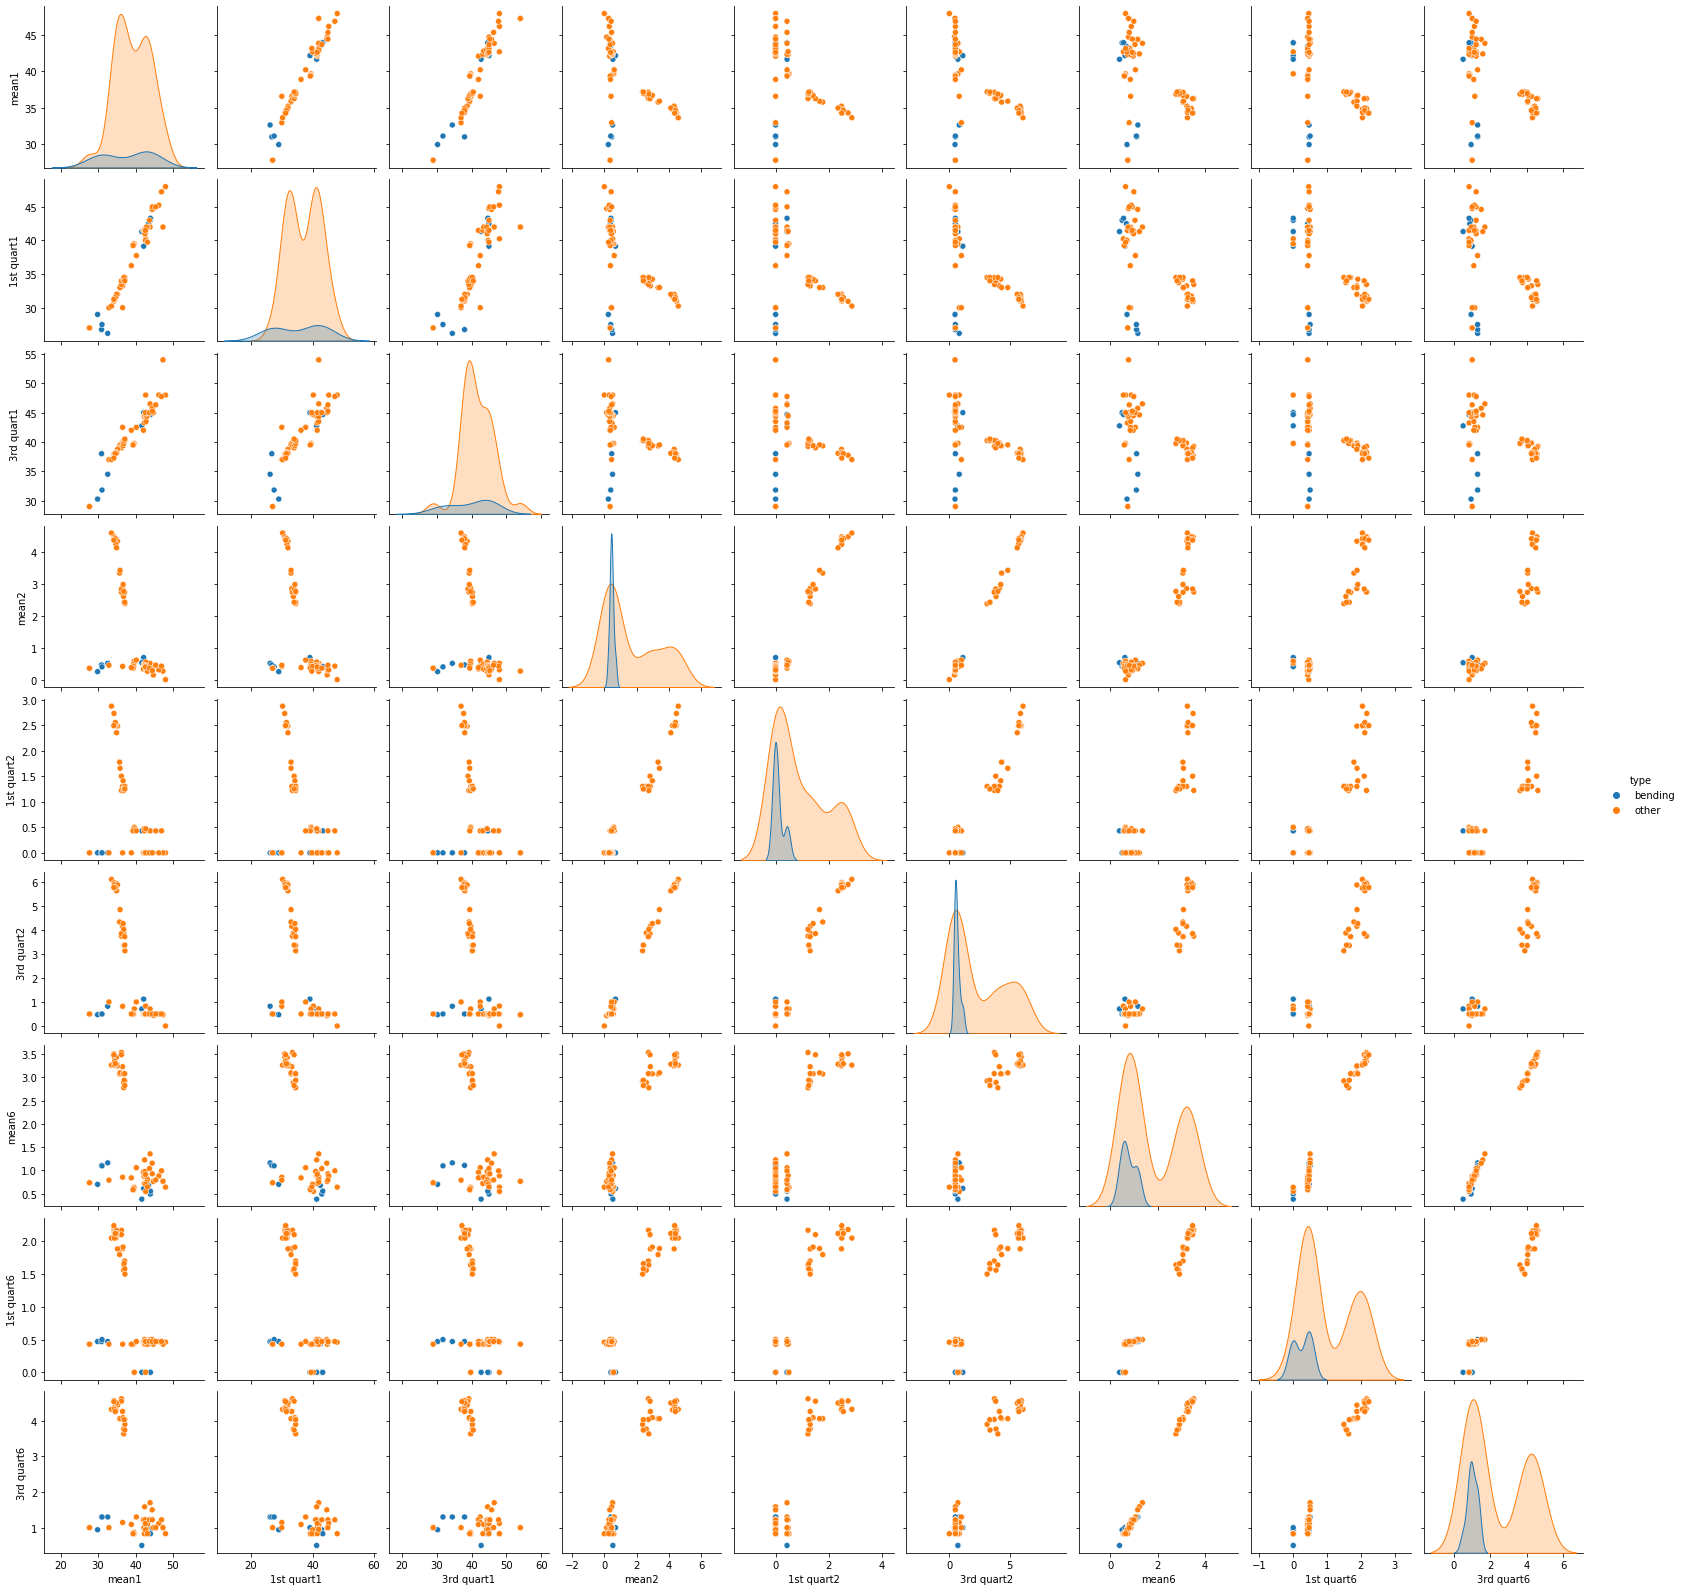

In [24]:
sns.pairplot(train_sum,hue='type')

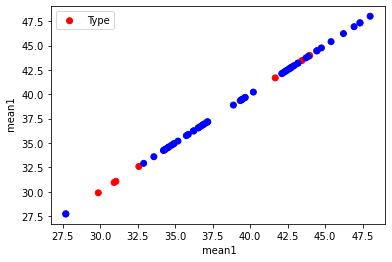

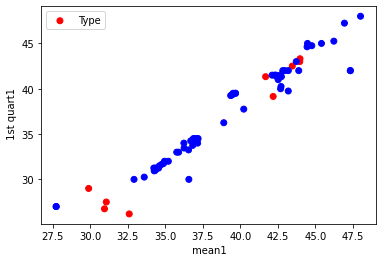

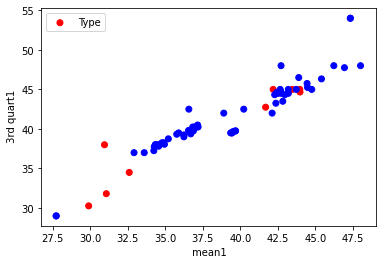

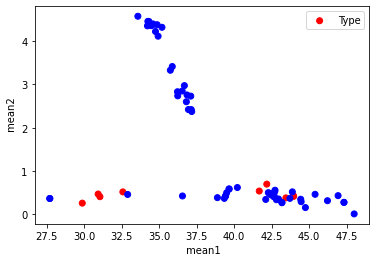

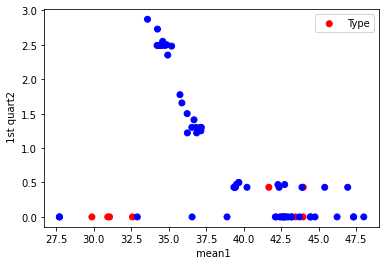

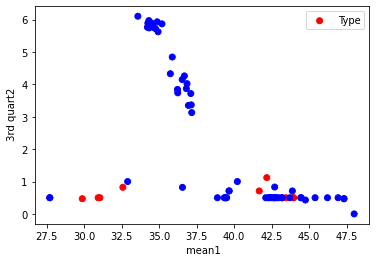

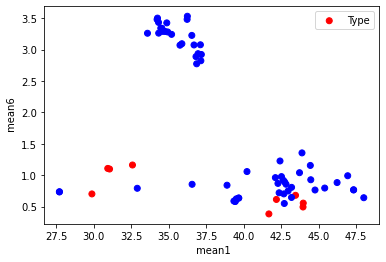

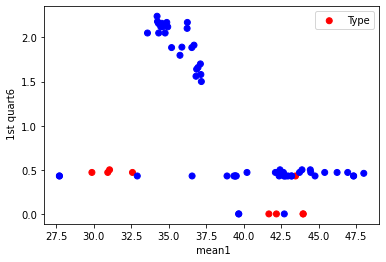

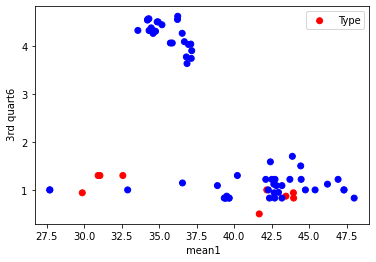

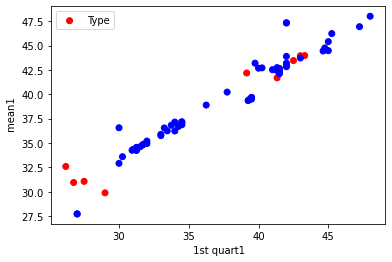

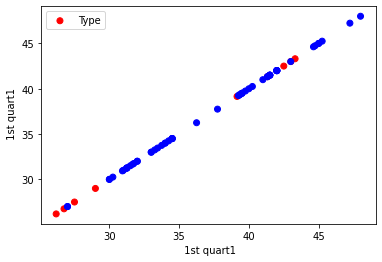

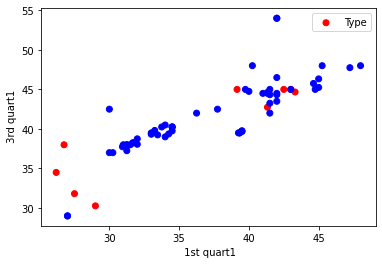

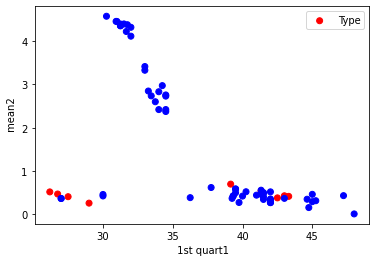

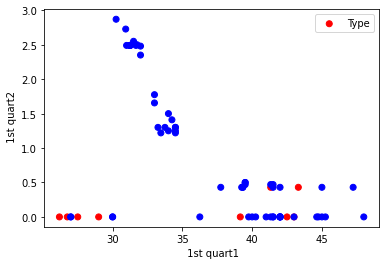

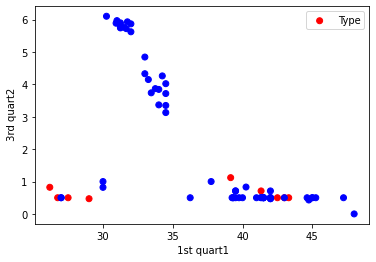

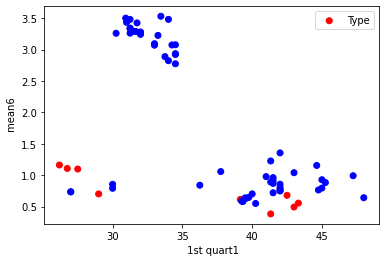

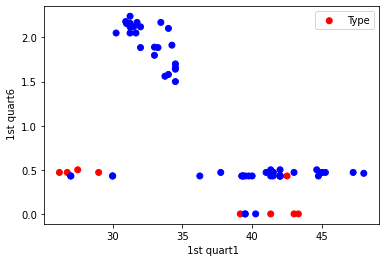

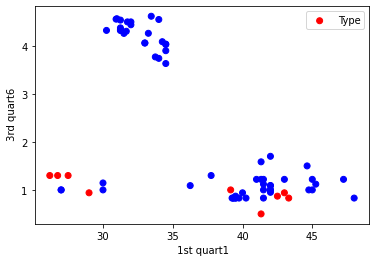

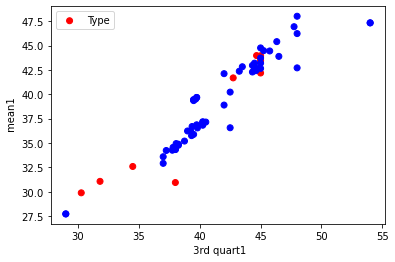

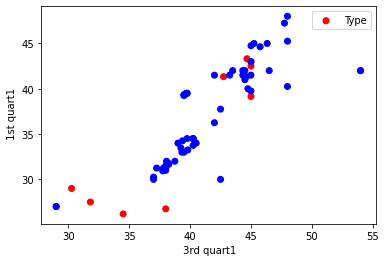

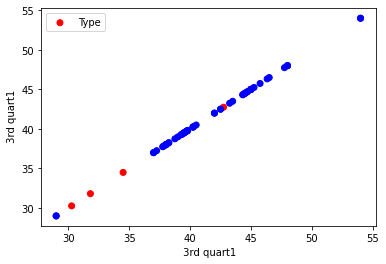

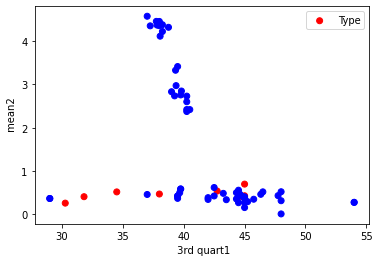

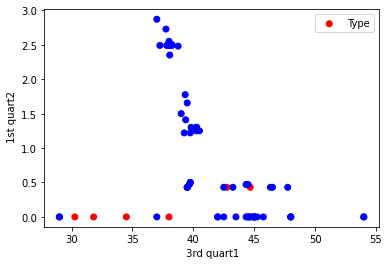

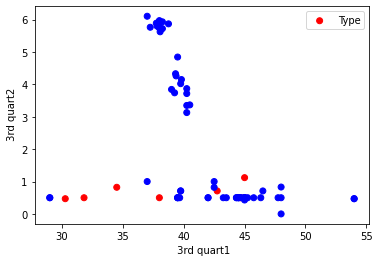

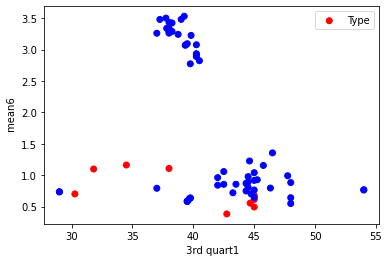

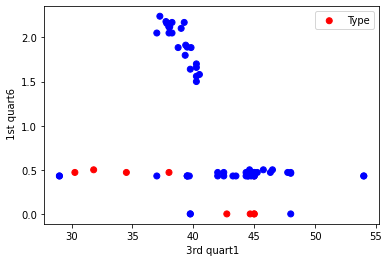

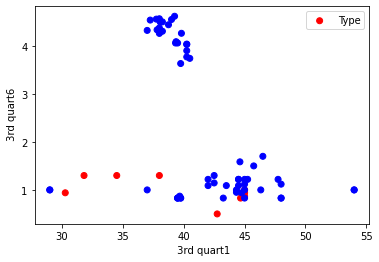

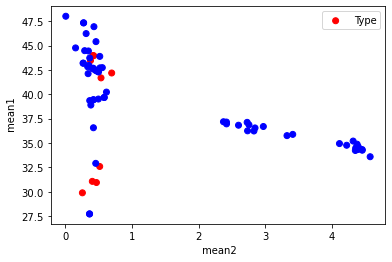

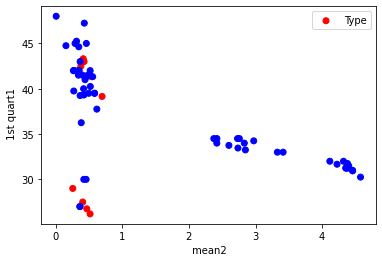

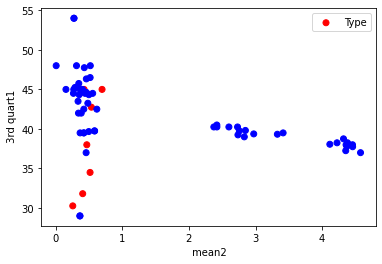

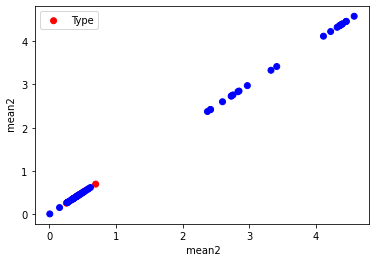

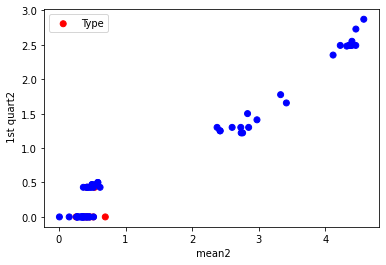

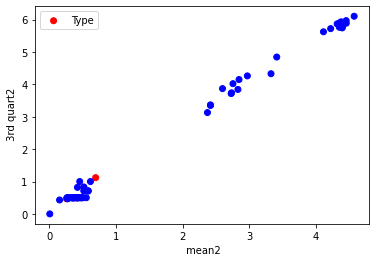

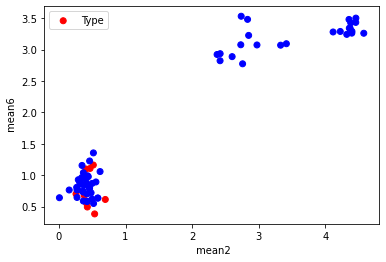

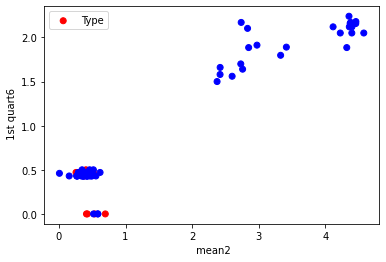

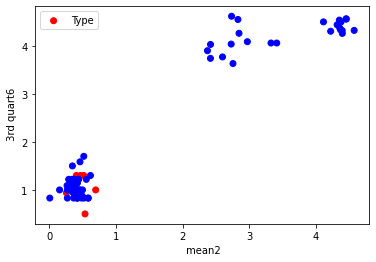

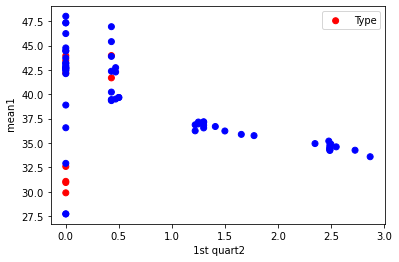

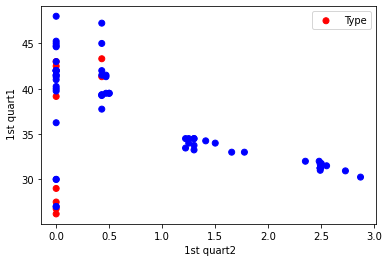

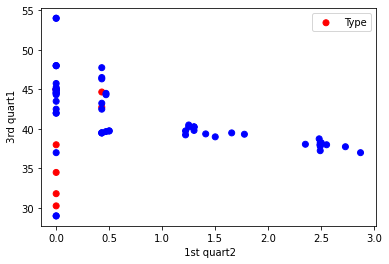

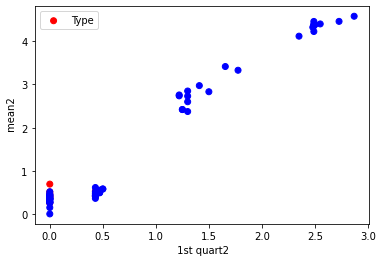

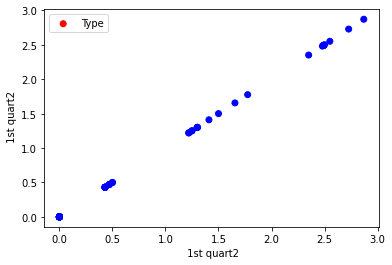

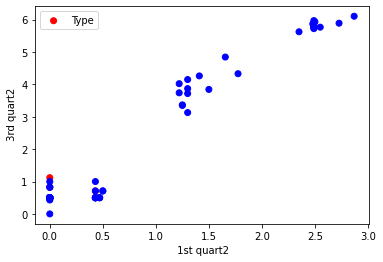

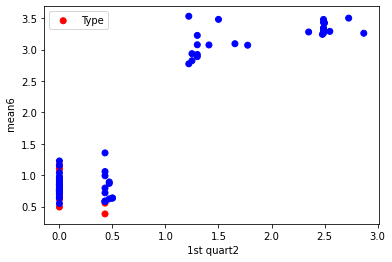

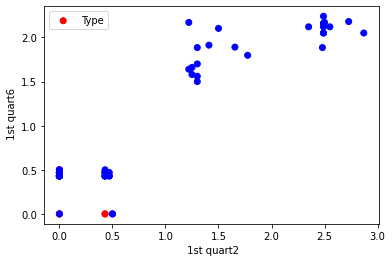

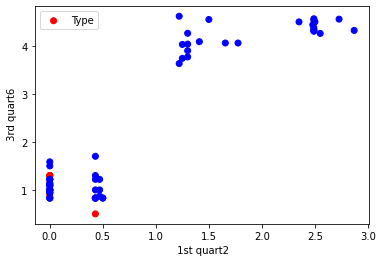

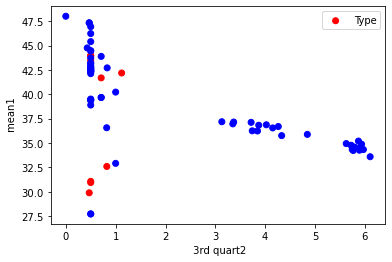

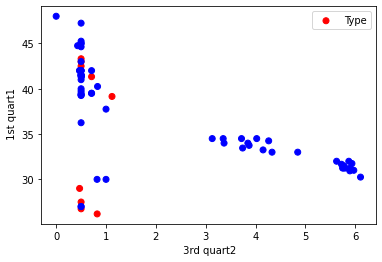

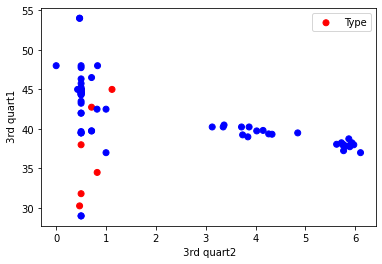

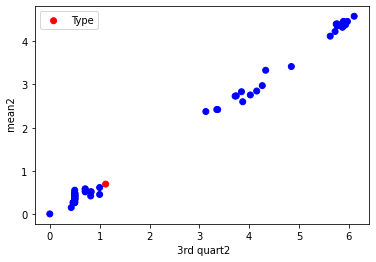

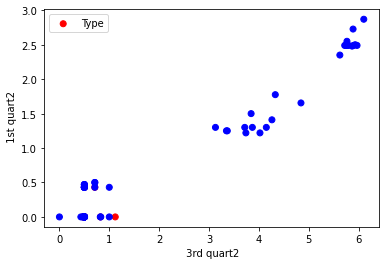

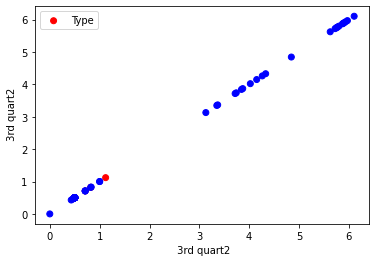

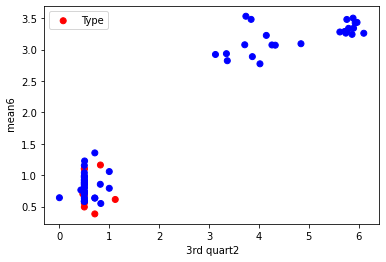

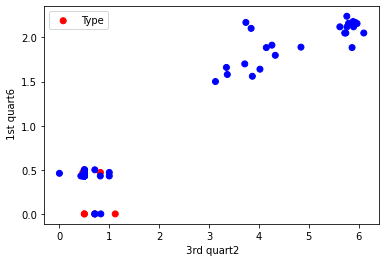

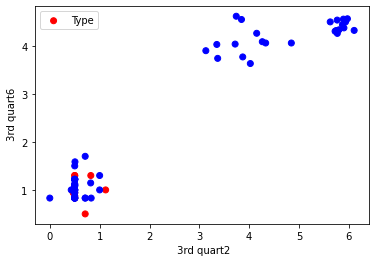

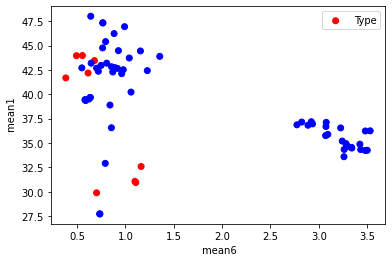

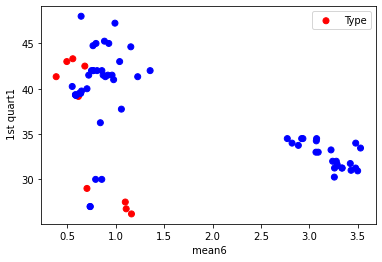

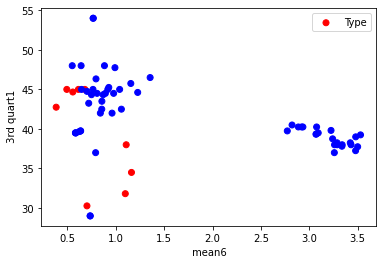

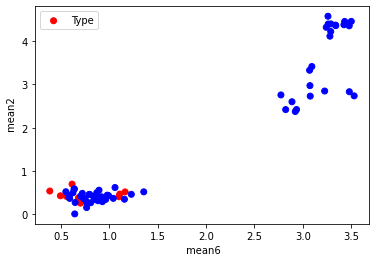

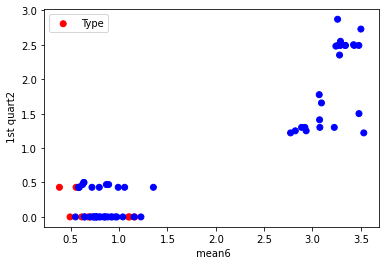

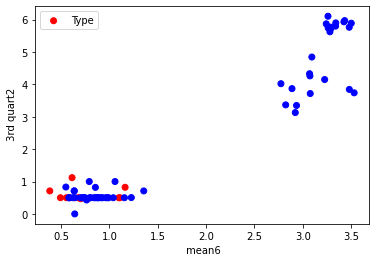

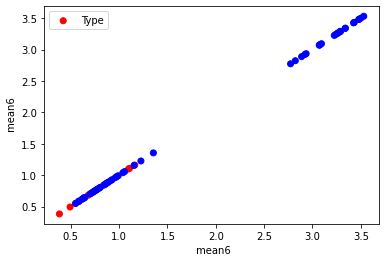

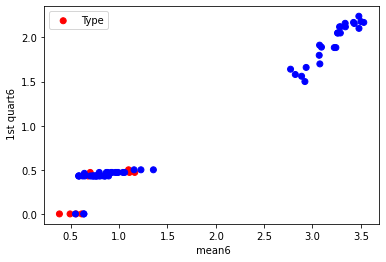

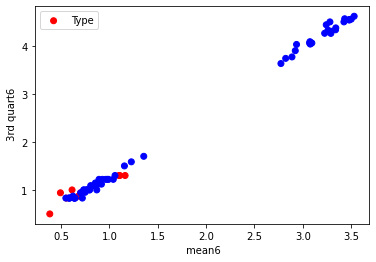

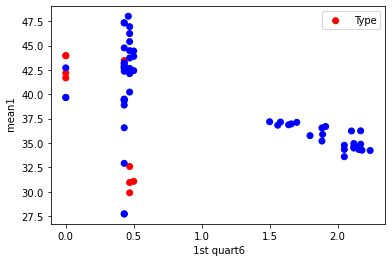

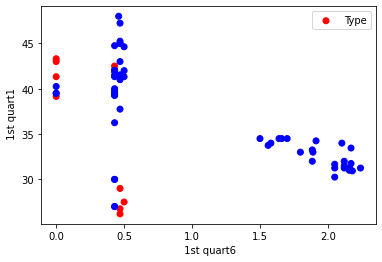

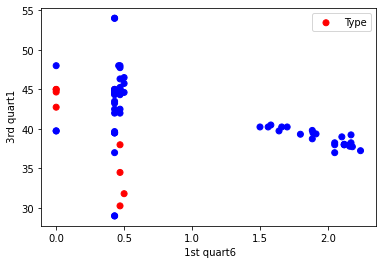

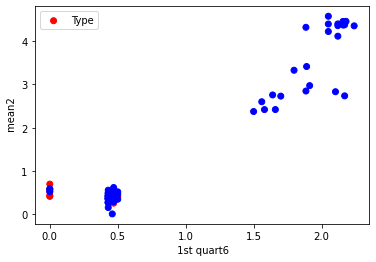

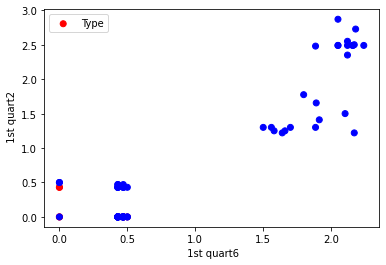

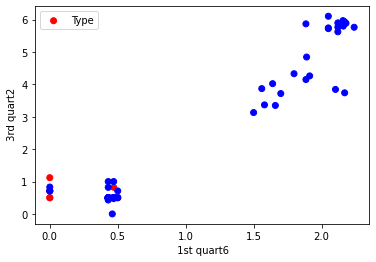

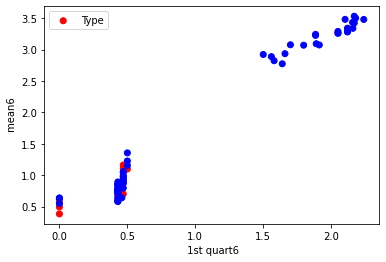

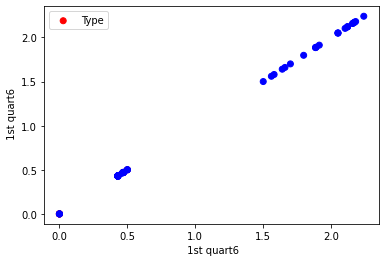

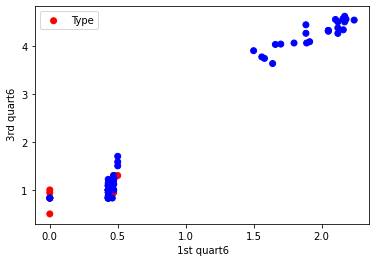

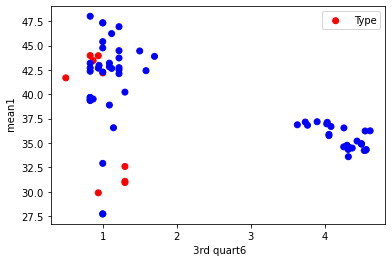

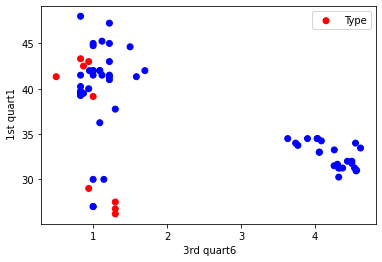

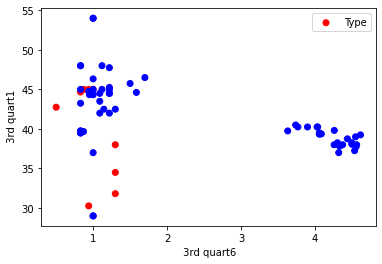

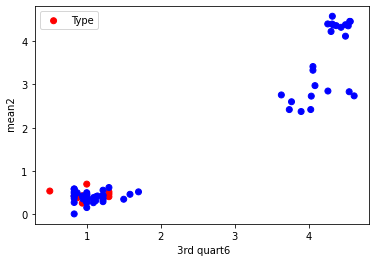

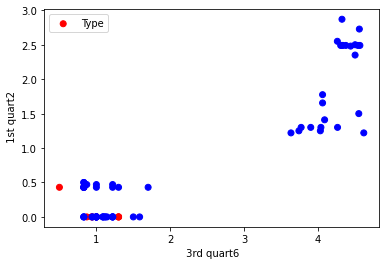

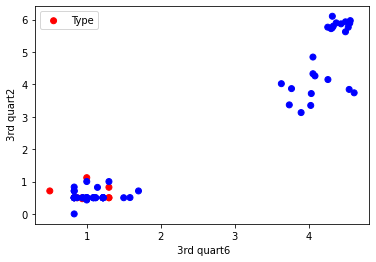

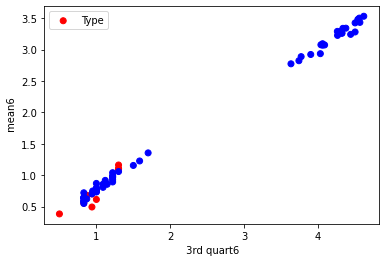

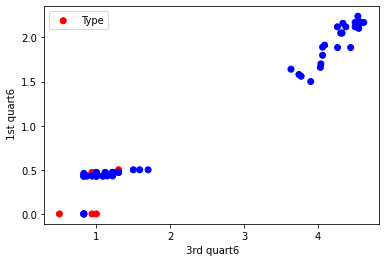

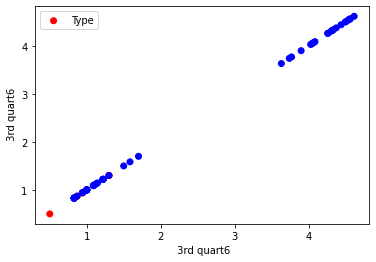

In [25]:
# Make a large one for details, there is a summary version that combines all plots above for trend analysis
# Define the colors for the scatter plot
colors = ['red' if val == 'bending' else 'blue' for val in train_sum.iloc[:, -1]]

# Create scatter plots for each pair of columns (0-8) with the last column used for color
for i in range(9):
    for j in range(9):
        plt.scatter(train_sum.iloc[:, i], train_sum.iloc[:, j], c=colors, label='Type')
        plt.xlabel(f' {train_sum.columns[i]}')
        plt.ylabel(f' {train_sum.columns[j]}')
        plt.legend()
        plt.show()


### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 4(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 4(a)i?

In [26]:
def split_dataset(data, num_splits):
    """Splits the given dataset into the given number of smaller datasets along the first axis."""
    assert num_splits > 0, "Number of splits must be greater than 0."
    
    if data.shape[0] % num_splits != 0:
        #print("Warning: Number of splits is not a factor of the dataset size. Adjusting number of splits.")
        num_splits = data.shape[0] // (data.shape[0] // num_splits)
    
    split_size = data.shape[0] // num_splits
    datasets = []
    
    for i in range(num_splits):
        start = i * split_size
        end = (i + 1) * split_size
        datasets.append(data[start:end])
    ds = np.array(datasets).reshape((split_size,num_splits*8))

    
    
    feature_names = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 
                    'var_rss13', 'avg_rss23', 'var_rss23', 'activity']
    feature_names = feature_names * num_splits
    
    ds = pd.DataFrame(ds,columns=feature_names)
    
    #a = pd.concat(datasets, axis=0)
    #a.columns = feature_names
    
    return ds

In [27]:
lst = [1, 2, 6]
# This function can give the proper number after each feature
def extend_list(lst, num_addition):
    # Loop to extend the list in the specified pattern
    for i in range(num_addition):
        n = len(lst)
        lst.extend([lst[-1]+2, lst[-1]+3, lst[-1]+7])        
    return lst


In [28]:
# Make a function that can make a summary table for any path with csv files that have those features
def summary_table3(path,num_splits):
    feature_name = ['avg_rss12', 'var_rss12', 'var_rss23']
    col_names = ['type']
    count = 0
    lst = [1, 2, 6]
    act_lst = extend_list(lst,num_splits-1)
     
    for i in act_lst:
        col_names.extend(['mean{}'.format(i),
                          '25% CI{}'.format(i),
                          '75% CI{}'.format(i)])

    final_table = pd.DataFrame(columns=col_names)

    for folder in folder_list:
        trial_path = os.path.join(path,folder)    
        files = [f for f in os.listdir(trial_path) if f.endswith('csv')] 
        for file in files:
            file_path=os.path.join(trial_path,file)
            
            trial_file = pd.read_csv(file_path)
            #Split the dataset using the split_dataset function
            split_table = split_dataset(trial_file,num_splits)
            table = split_table.agg(['mean','std','median']) # Get the features
            table_select = table.iloc[:,act_lst]
            # Manually calculate the 25% and 75% CIs with the std and median we got above
            table_select.loc['25%'] = table_select.iloc[0,:].values - table_select.iloc[1,:].values
            table_select.loc['75%'] = table_select.iloc[0,:].values + table_select.iloc[1,:].values
            table_select = table_select.drop(['std','median']) # Drop these two features
            
            table_18 = table_select.values.T.flatten()
            t18 = pd.DataFrame(table_18).T
            t18.insert(0,'type',folder)
            t18.columns = col_names
            

            final_table = pd.concat([t18,final_table],ignore_index=True)


    return(final_table)

In [29]:
# Ignore all warnings
warnings.filterwarnings("ignore")

half_split_table = summary_table3('../data/train_data',2)
half_split_table.loc[:, 'type'] = half_split_table['type'].replace('bending1', 'bending')
half_split_table.loc[:, 'type'] = half_split_table['type'].replace('bending2', 'bending')
for t in half_split_table['type'].unique():
    if t != 'bending':
        half_split_table.loc[:, 'type'] = half_split_table['type'].replace(t, 'other')
half_split_table


,type,mean1,25% CI1,75% CI1,mean2,25% CI2,75% CI2,mean6,25% CI6,75% CI6,mean8,25% CI8,75% CI8,mean9,25% CI9,75% CI9,mean13,25% CI13,75% CI13
0,other,34.404917,29.880989,38.928844,4.336125,1.706662,6.965588,3.506458,1.721737,5.29118,34.046833,29.686629,38.407038,4.372875,1.964054,6.781696,3.452625,1.712061,5.193189
1,other,34.494542,29.758632,39.230452,4.29325,1.659805,6.926695,3.289833,1.630743,4.948924,34.705208,29.969997,39.440419,4.504417,2.063573,6.945261,3.28925,1.584794,4.993706
2,other,34.310792,29.080741,39.540843,4.312417,1.916648,6.708185,3.283958,1.612826,4.955091,34.355292,29.693887,39.016696,4.4815,1.74841,7.21459,3.239208,1.674438,4.803979
3,other,34.955958,29.846521,40.065396,3.87575,1.636427,6.115073,3.2035,1.492544,4.914456,34.915667,30.77408,39.057254,4.35575,1.94758,6.76392,3.356542,1.66562,5.047464
4,other,34.765917,30.101991,39.429843,4.396875,2.046981,6.746769,3.284542,1.716695,4.852388,34.76075,29.93178,39.58972,4.050708,1.85568,6.245737,3.292,1.565188,5.018812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,bending,43.969292,42.349446,45.589138,0.410667,0.152715,0.668619,0.555625,0.044716,1.066534,43.968958,42.348693,45.589223,0.415583,0.146896,0.684271,0.555,0.090332,1.019668
65,bending,43.464583,42.060729,44.868438,0.378417,0.061755,0.695078,0.66925,0.148185,1.190315,43.445333,42.074356,44.816311,0.37775,0.062621,0.692879,0.690042,-0.020586,1.40067
66,bending,41.691042,39.472363,43.90972,0.54475,0.114769,0.974731,0.379375,-0.010808,0.769558,41.665083,39.392489,43.937677,0.527208,0.14713,0.907287,0.387208,-0.001711,0.776127
67,bending,42.194083,38.510323,45.877844,0.687833,0.08079,1.294877,0.591833,0.081472,1.102195,42.165542,38.500375,45.830709,0.70425,0.049271,1.359229,0.635208,0.097106,1.17331


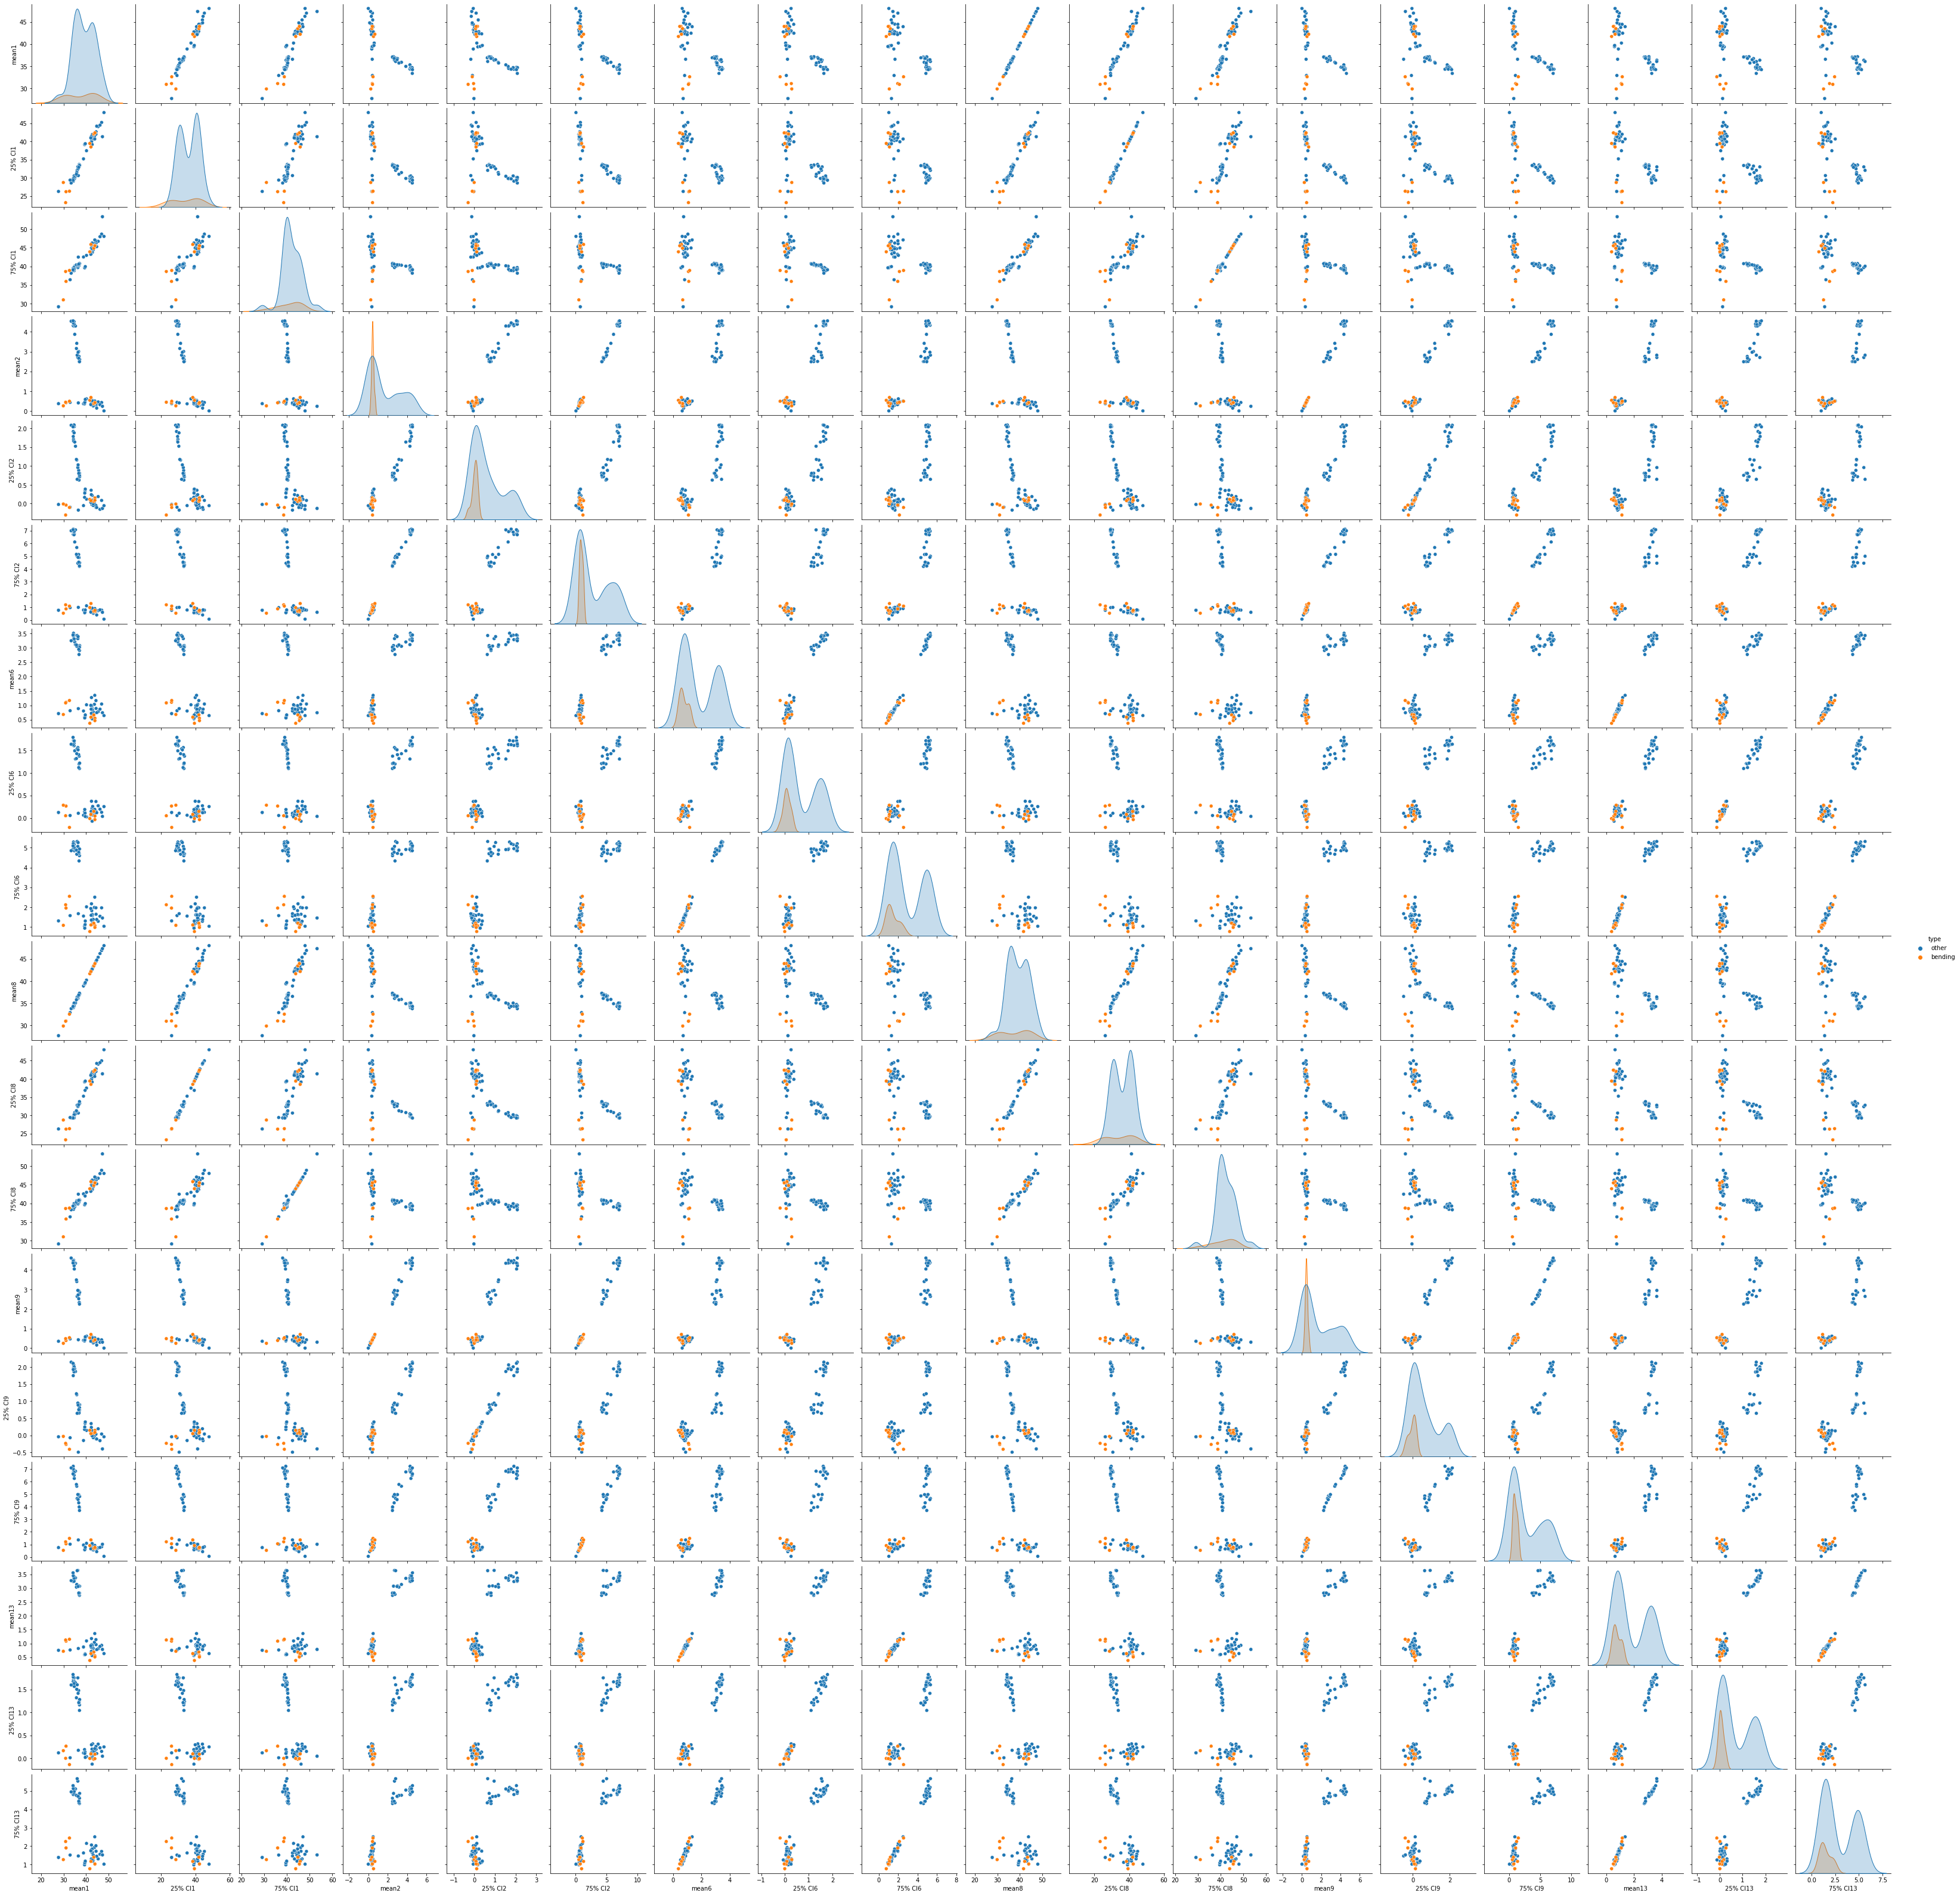

In [30]:
p2 = sns.pairplot(half_split_table,hue='type')
plt.show()

### iii. Break each time series in your training set into $l \in \{1,2,...,20\}$ time series of approximately equal length and use logistic regression $^5$ to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. 
### Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. $^6$
### Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l; p), where p is the number of features used in recursive feature elimination.
### Explain what the right way and the wrong way are to perform cross-validation in this problem. $^7$ Obviously, use the right way! 
### Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.
### In the following, you can see an example of applying Python's Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.

In [34]:

l_list = range(1,21)
cv = []
p_values = pd.DataFrame(columns=['l number','p-val'])
accuracy_list = pd.DataFrame(columns=['l number','accuracy_score'])
sel_cols = pd.DataFrame(columns=['l number','columns'])
count = 0

# Loop inside the l_list to find the best model based on p-val for each fold
for l in range(1, 21):
    trial_split = summary_table3('../data/train_data',l)

    # Split the dataset into l parts
    print(l)
    trial_split['type'] = trial_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], 0)


    X_splits = trial_split.iloc[:,1:]

    y = trial_split['type']

    # Initialize logistic regression model
    model = LogisticRegression(solver='lbfgs', max_iter=10000)
    # Initialize RFECV object
    rfecv = RFECV(estimator=model, cv=5,scoring='accuracy',n_jobs=-1)
    #print('initializing RFECV:',count)
    # Fit RFECV object to data
    rfecv.fit(X_splits, y)
    #print('fitting:',count)


    # Get the optimal number of features
    n_features = rfecv.n_features_
#    print('getting opt p:',count,n_features)
 
    # Get the indices of the selected features
    feature_indices = rfecv.get_support(indices=True)
    # Get the corresponding column names
    selected_columns = X_splits.columns[feature_indices]
    sel_cols = sel_cols.append({'l number':l,'columns':selected_columns},ignore_index=True)
#     print('columns are: ',selected_columns, count)

# Fit a logistic regression model to the selected features
    X_selected = X_splits.iloc[:, feature_indices]
    
    log_reg = sm.Logit(np.array(y), np.array(X_selected,dtype=float)).fit()

    # Get the p-values for the selected features
    p_value = log_reg.pvalues
    p_values = p_values.append({'l number':l,'p-val':p_value},ignore_index=True)
    accuracy_list = accuracy_list.append({'l number':l,'accuracy_score':np.mean(rfecv.grid_scores_[n_features-1])},ignore_index=True) 
# print(p_values,accuracy_list)

max_acc_a = max(accuracy_list['accuracy_score'])
# opt_l = accuracy_list['l number'][accuracy_list['accuracy_score'].idxmax()]
opt_l = accuracy_list['l number'].iloc[np.argmax(accuracy_list['accuracy_score'])]
opt_p= p_values.loc[p_values['l number'] == opt_l, 'p-val'].iloc[0]
opt_col = sel_cols.loc[sel_cols['l number'] == opt_l, 'columns'].iloc[0]
                                  
                                  
                                  
print('optimal l is: ',opt_l,'\n','Accuracy is:',max_acc_a,'\n','selected columns are:',opt_col,'\n','corresponding p-values are: ', opt_p)


1
Optimization terminated successfully.
         Current function value: 0.321828
         Iterations 8
2
Optimization terminated successfully.
         Current function value: 0.320789
         Iterations 8
3
Optimization terminated successfully.
         Current function value: 0.266670
         Iterations 10
4
Optimization terminated successfully.
         Current function value: 0.287800
         Iterations 9
5
Optimization terminated successfully.
         Current function value: 0.342300
         Iterations 9
6
Optimization terminated successfully.
         Current function value: 0.289619
         Iterations 9
7
Optimization terminated successfully.
         Current function value: 0.283606
         Iterations 10
8
Optimization terminated successfully.
         Current function value: 0.323881
         Iterations 9
9
Optimization terminated successfully.
         Current function value: 0.275331
         Iterations 9
10
Optimization terminated successfully.
         Current func

# Sample Python Code

In [ ]:
# from sklearn import datasets
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# dataset = datasets.load_iris()
# model = LogisticRegression()

# rfe = RFE(model, 3)
# rfe = rfe.fit(dataset.data, dataset.target)

# print(rfe.support_)
# print(rfe.ranking_)


#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression  $\beta_i$'s as well as the p-values associated with them.

parameters selected are:  Index(['mean27', '25% CI55', '75% CI90'], dtype='object') 
 their associated p-vals are:  [0.90611461 0.02639608 0.42970714]
Confusion Matrix:
[[60  0]
 [ 9  0]]
AUC: 0.8314814814814814


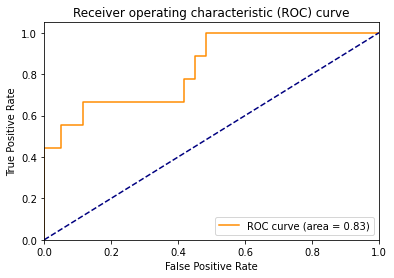

In [35]:

opt_split = summary_table3('../data/train_data',int(opt_l))

opt_split['type'] = opt_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], 0)

y = opt_split['type']

X_opt = opt_split[opt_col]
print('parameters selected are: ',opt_col,'\n','their associated p-vals are: ',opt_p)
# assume X_train and y_train are your training data
model = LogisticRegression()
model.fit(X_opt, y)

# make predictions on the training data
y_pred_train = model.predict(X_opt)

# generate the confusion matrix
cm = confusion_matrix(y, y_pred_train)
print("Confusion Matrix:")
print(cm)

# generate the ROC curve and calculate AUC
y_prob_test = model.predict_proba(X_opt)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_prob_test)
auc_score = auc(fpr, tpr)
print("AUC:", auc_score)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


#### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

accuracy is:  0.7894736842105263
Confusion Matrix:
[[15  0]
 [ 4  0]]
AUC: 0.7333333333333334


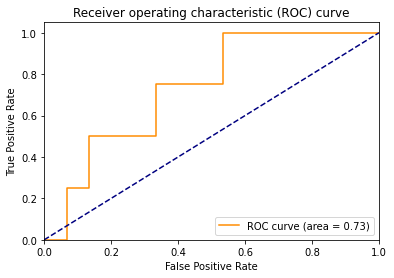

In [38]:
# Returning the test error based on the pruned parameters, and plot the AUC ROC on the test data.


opt_split = summary_table3('../data/train_data',int(opt_l))
opt_split['type'] = opt_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], 0)
y = opt_split['type']
X_opt = opt_split[opt_col]

opt_split_test = summary_table3('../data/test_data',int(opt_l))
opt_split_test['type'] = opt_split_test['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], 0)
y_test = opt_split_test['type']
X_opt_test = opt_split_test[opt_col]


# # assume X_train and y_train are your training data
# model = LogisticRegression()
# model.fit(X_opt, y)

# # make predictions on the training data
# y_pred_test = model.predict(X_opt_test)


model1 = LogisticRegression(solver='lbfgs', max_iter=10000)
# Initialize RFECV object
model = RFECV(estimator=model1, cv=5,scoring='accuracy',n_jobs=-1)
#print('initializing RFECV:',count)
# Fit RFECV object to data
model.fit(X_opt, y)
y_pred_test = model.predict(X_opt_test)
accuracy = accuracy_score(y_test, y_pred_test)

print('accuracy is: ',accuracy)



# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# generate the ROC curve and calculate AUC
y_prob_test = model.predict_proba(X_opt_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
auc_score = auc(fpr, tpr)
print("AUC:", auc_score)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


#### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

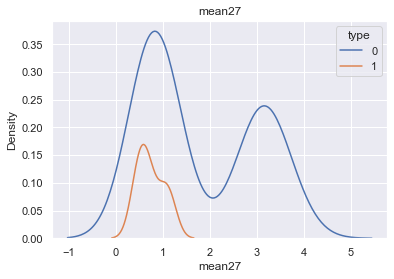

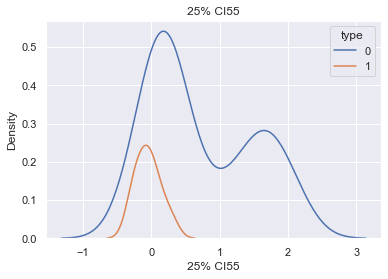

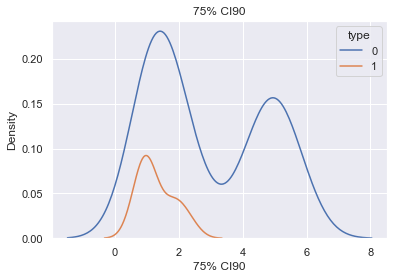

In [39]:
# Create density plot for each column with different color for differernt type to check


opt_split = summary_table3('../data/train_data',int(opt_l))
opt_split['type'] = opt_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], 0)
y = opt_split['type']
X_opt = opt_split[opt_col]
data = X_opt.join(y)


cols = [col for col in data.columns if col != "type"]

# set plot style
sns.set(style="darkgrid")

# loop through columns and plot kde plot for each column
for col in cols:
    fig, ax = plt.subplots()
    sns.kdeplot(data=data, x=col, hue="type", ax=ax)
    plt.title(col)
    plt.show()

### <span style='color:blue '>From the plots above we can see that there are significant amount of overlap. Thus, it's safe to say that it can cause instability in calculating logistic regression parameters because the model may be having trouble distinguishing between the two classes.<span>

#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

### <span style='color:blue '> Yes, there are imbalanced classes.<span>

Confusion Matrix:
 [[19  1]
 [ 1  0]]


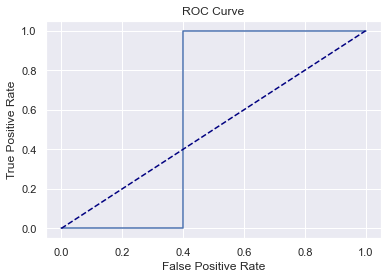

AUC: 0.6


In [41]:

# Load the dataset
df = summary_table3('../data/train_data',int(opt_l))
df['type'] = df['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], 0)

X = df.drop('type', axis=1)
y = df['type']


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Combine the training data back together
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the positive and negative classes
positive = train_data[train_data['type'] == 1]
negative = train_data[train_data['type'] == 0]

# Oversample the minority class (positive class)
oversampled = resample(positive, replace=True, n_samples=len(negative), random_state=42)

# Combine the oversampled minority class with the majority class
train_oversampled = pd.concat([negative, oversampled])

# Separate the target variable and predictors
X_train_oversampled = train_oversampled.drop('type', axis=1)
y_train_oversampled = train_oversampled['type']

# Train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_oversampled, y_train_oversampled)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

# Compute the ROC curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute the AUC score
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC:', auc)


### (b) Binary Classification Using L1-penalized logistic regression

#### i. Repeat 4(a)iii using $L_{1}$-penalized logistic regression, $^8$ i.e. instead of using p-values for variable selection, use $L_1$ regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and  $\lambda$, the weight of $L_1$ penalty in your logistic regression objective function (or $C$, the budget). Packages usually perform cross-validation for $\lambda$  automatically. $^9$

In [43]:

l_list = range(1,11)
cv = []
lambda_list_b = pd.DataFrame(columns=['l number','lam'])
accuracy_list_b = pd.DataFrame(columns=['l number','accuracy_score'])
selected_col_b = pd.DataFrame(columns=['l number','columns'])

count = 0
# Loop inside the l_list to find the best model based on p-val for each fold
for l in range(1, 21):
    # Split the dataset into l parts
    trial_split = summary_table3('../data/train_data',l)

    # Split the dataset into l parts
    #print(l)
    trial_split['type'] = trial_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], 0)


    X_splits = trial_split.iloc[:,1:]

    y = trial_split['type']

    # Initialize logistic regression model
    model = LogisticRegressionCV(Cs=list(range(1,11)),penalty='l1',cv=5,scoring='accuracy',solver='liblinear').fit(X_splits,y)
    
    lambda_list_b = lambda_list_b.append({'l number':l,'lam':model.C_},ignore_index=True)

    accuracy_list_b = accuracy_list_b.append({'l number':l,'accuracy_score':model.scores_[1].mean()},ignore_index=True) 
    
    col = model.coef_[0]!=0
    
    sel_col_b = [X_splits.columns[i] for i, x in enumerate(col) if x]
    
    selected_col_b = selected_col_b.append({'l number':l,'column':sel_col_b},ignore_index=True)

max_acc_b = max(accuracy_list_b['accuracy_score'])
opt_l_b = accuracy_list_b['l number'].iloc[np.argmax(accuracy_list_b['accuracy_score'])]
opt_lambda_b = lambda_list_b.loc[lambda_list_b['l number'] == opt_l_b, 'lam']
opt_col_b = selected_col_b.loc[selected_col_b['l number'] == opt_l_b, 'column']

In [44]:
print('optimal l is: ',opt_l_b,'\n','selected columns are:',opt_col_b,'\n','Accuracy is: ',max_acc_b,'\n','optimal lambda is: ',opt_lambda_b)


optimal l is:  19.0 
 selected columns are: 18    [25% CI1, 75% CI1, 25% CI8, 75% CI9, 75% CI15,...
Name: column, dtype: object 
 Accuracy is:  0.8617582417582418 
 optimal lambda is:  18    [10]
Name: lam, dtype: object


#### ii. Compare the $L_1$-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

### <span style='color:blue'>In terms of the accuracy, the one without $L_1$ penalty acutually have a better performance. In terms of implementation difficulty, since there are existing packages in python for this, I believe with the $L_1$ penalty is easier.<span>

### (c) Multi-class Classification (The Realistic Case)

#### i. Find the best l in the same way as you found it in 4(b)i to build an $L_1$-penalized multinomial regression model to classify all activities in your training set. $^{10}$ Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible. $^{11}$

In [46]:
# Finding the best l and lambda pair

l_list = range(1,11)
cv = []
lambda_list_c = pd.DataFrame(columns=['l number','lam'])
accuracy_list_c = pd.DataFrame(columns=['l number','accuracy_score'])
selected_col_c = pd.DataFrame(columns=['l number','columns'])

count = 0
# Loop inside the l_list to find the best model based on p-val for each fold
for l in range(1, 21):
    # Split the dataset into l parts
    trial_split = summary_table3('../data/train_data',l)

    # Split the dataset into l parts
    trial_split['type']=trial_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking'],2).replace(
        ['standing', 'sitting', 'lying', 'cycling'], [3,4,5,6])

    X_splits = trial_split.iloc[:,1:]

    y = trial_split['type']

    # Initialize logistic regression model
    model = LogisticRegressionCV(Cs=list(range(1,11)),penalty='l1',cv=5,scoring='accuracy',solver='liblinear').fit(X_splits,y)
    
    lambda_list_c = lambda_list_c.append({'l number':l,'lam':model.C_},ignore_index=True)

    accuracy_list_c = accuracy_list_c.append({'l number':l,'accuracy_score':model.scores_[1].mean()},ignore_index=True) 
    
    col = model.coef_[0]!=0
    
    sel_col_c = [X_splits.columns[i] for i, x in enumerate(col) if x]
    
    selected_col_c = selected_col_c.append({'l number':l,'column':sel_col_c},ignore_index=True)

max_acc_c = max(accuracy_list_c['accuracy_score'])
opt_l_c = accuracy_list_c['l number'].iloc[np.argmax(accuracy_list_c['accuracy_score'])]
opt_lambda_c = lambda_list_c.loc[lambda_list_c['l number'] == opt_l_c, 'lam']
opt_col_c = selected_col_c.loc[selected_col_c['l number'] == opt_l_c, 'column']
print('optimal l is: ',opt_l_c,'\n','selected columns are:',opt_col_c,'\n','Accuracy is: ',max_acc_c,'\n','optimal lambda is: ',opt_lambda_c)


optimal l is:  12.0 
 selected columns are: 11    [75% CI6, 25% CI22, 75% CI22, 25% CI27, 25% CI...
Name: column, dtype: object 
 Accuracy is:  0.9023076923076924 
 optimal lambda is:  11    [6, 1, 1, 2, 6, 5]
Name: lam, dtype: object


Test Accuracy is:  0.631578947368421
Confusion Matrix:
[[2 0 0 2 0 0]
 [0 2 0 0 0 1]
 [0 0 2 1 0 0]
 [0 0 2 1 0 0]
 [1 0 0 0 2 0]
 [0 0 0 0 0 3]]


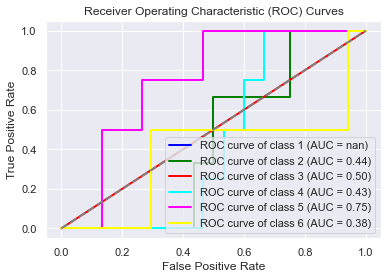

In [47]:
# Reporting the test error and the ROC curve for all types

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


opt_split = summary_table3('../data/train_data',int(opt_l_c))
opt_split['type']=opt_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking'],2).replace(
        ['standing', 'sitting', 'lying', 'cycling'], [3,4,5,6])
y = opt_split['type']
X_opt = opt_split[opt_col_c.iloc[0]]

opt_split_test = summary_table3('../data/test_data',int(opt_l_c))
opt_split_test['type'] = opt_split_test['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], [2,3,4,5,6])
y_test = opt_split_test['type']
X_opt_test = opt_split_test[opt_col_c.iloc[0]]


# assume X_train and y_train are your training data
model = LogisticRegressionCV(Cs=3,penalty='l1',cv=5,scoring='accuracy',solver='liblinear')
model.fit(X_opt, y)

# make predictions on the training data
y_pred_test = model.predict(X_opt_test)

accuracy = accuracy_score(y_test, y_pred_test)
print('Test Accuracy is: ',accuracy)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Compute the ROC curve and AUC for each class
n_classes = 6
y_score = model.decision_function(X_opt_test)
y_test_binarized = label_binarize(y_pred_test, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure()
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


#### ii. Repeat 4(c)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

In [48]:
# Use Gaussian prior

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

l_list = range(1, 21)
cv = []

accuracy_list_d = pd.DataFrame(columns=['l number','accuracy_score'])
var_smooth = pd.DataFrame(columns=['l number','params'])


for l in l_list:
    # Split the dataset into l parts
    trial_split = summary_table3('../data/train_data', l)

    # Replace the target labels with numbers
    trial_split['type'] = trial_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], [2,3,4,5,6])

    X_splits = trial_split.iloc[:, 1:]
    y = trial_split['type']

    # Split data into features and target
    X = trial_split.iloc[:, 1:]
    y = trial_split['type']

    # Define parameter grid
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

    # Create Gaussian Naive Bayes model
    nb = GaussianNB()

    # Create GridSearchCV object
    grid = GridSearchCV(nb, param_grid, cv=5)

    # Fit the model using GridSearchCV
    grid.fit(X, y)
    
    var_smooth = var_smooth.append({'l number':l,'params':grid.best_params_['var_smoothing']},ignore_index=True)
    accuracy_list_d = accuracy_list_d.append({'l number':l,'accuracy':grid.best_score_},ignore_index=True)

# Print the best hyperparameters and accuracy score
max_acc_d = max(accuracy_list_d['accuracy'])
opt_l_d = accuracy_list_d['l number'][accuracy_list_d['accuracy'].idxmax()]
opt_var_smooth = var_smooth.loc[var_smooth['l number'] == opt_l_c, 'params']
print('optimal l is: ',opt_l_d,'\n','selected columns are:',opt_var_smooth,'\n','Accuracy is: ',max_acc_d)

optimal l is:  19.0 
 selected columns are: 11    0.0
Name: params, dtype: object 
 Accuracy is:  0.7373626373626374


In [51]:
# Using Multinomial prior
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

l_list = range(1, 21)
cv = []
lambda_list_di = pd.DataFrame(columns=['l number','lam'])
accuracy_list_di = pd.DataFrame(columns=['l number','accuracy_score'])
selected_col_di = pd.DataFrame(columns=['l number','columns'])

# Loop inside the l_list to find the best model based on p-val for each fold
for l in l_list:
    # Split the dataset into l parts
    trial_split = summary_table3('../data/train_data', l)

    # Replace the target labels with numbers
    trial_split['type'] = trial_split['type'].replace(['bending1', 'bending2'], 1).replace(['walking', 'standing', 'sitting', 'lying', 'cycling'], [2,3,4,5,6])

    X_splits = trial_split.iloc[:, 1:]
    X_splits = X_splits**2 # Since there are negtive values, I need to transform them into positive values
    y = trial_split['type']

    # Initialize Naive Bayes model
    model = MultinomialNB()

    # Use cross validation to find the best hyperparameters
    params = {'alpha': list(range(1, 11))}
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='accuracy')
    grid_search.fit(X_splits, y)

    lambda_list_di = lambda_list_di.append({'l number':l, 'lam':grid_search.best_params_['alpha']}, ignore_index=True)
    accuracy_list_di = accuracy_list_di.append({'l number':l, 'accuracy_score':grid_search.best_score_}, ignore_index=True)
    
    col = grid_search.best_estimator_.coef_[0] != 0
    sel_col_di = [X_splits.columns[i] for i, x in enumerate(col) if x]
    selected_col_di = selected_col_di.append({'l number':l, 'columns':sel_col_di}, ignore_index=True)

max_acc_di = max(accuracy_list_di['accuracy_score'])
opt_l_di = accuracy_list_di['l number'].iloc[np.argmax(accuracy_list_di['accuracy_score'])]
opt_lambda_di = lambda_list_di.loc[lambda_list_di['l number'] == opt_l_di, 'lam']
opt_col_di = selected_col_di.loc[selected_col_di['l number'] == opt_l_di, 'columns']
print('optimal l is: ',opt_l_di,'\n','selected columns are:',opt_col_di,'\n','Accuracy is: ',max_acc_di,'\n','optimal lambda is: ',opt_lambda_di)


optimal l is:  5.0 
 selected columns are: 4    [mean1, 25% CI1, 75% CI1, mean2, 25% CI2, 75% ...
Name: columns, dtype: object 
 Accuracy is:  0.5384615384615385 
 optimal lambda is:  4    10
Name: lam, dtype: object


#### iii. Which method is better for multi-class classification in this problem?

### <span style='color:blue'> I like gaussian better, it can take negative values, so I don't need to worry about potentially ruin the relationship between Xs and Y. Also, Gaussian prior is easier to implement.<span>

This problem relates to the QDA model. Given a feature \( X \) and class \( k \), the likelihood of \( X \) is:

$$ f_k(x) = \frac{1}{\sqrt{2\pi\sigma_k^2}} e^{-\frac{(x - \mu_k)^2}{2\sigma_k^2}} $$

This is the density function for a one-dimensional normal distribution with mean \( \mu_k \) and variance \( \sigma_k^2 \).

The Bayes classifier assigns an observation \( X = x \) to the class \( k \) for which:

$$ \pi_k f_k(x) $$

is largest, where \( \pi_k \) is the prior probability that a randomly chosen observation comes from the \( k^{th} \) class.

To derive the Bayes classifier, we'll compare two classes, \( k \) and \( l \), and see under what conditions:

$$ \pi_k f_k(x) > \pi_l f_l(x) $$

Expanding using the density function:

$$ \pi_k \frac{1}{\sqrt{2\pi\sigma_k^2}} e^{-\frac{(x - \mu_k)^2}{2\sigma_k^2}} > \pi_l \frac{1}{\sqrt{2\pi\sigma_l^2}} e^{-\frac{(x - \mu_l)^2}{2\sigma_l^2}} $$

Taking the logarithm on both sides to simplify:

$$ \log(\pi_k) - \frac{1}{2} \log(2\pi\sigma_k^2) - \frac{(x - \mu_k)^2}{2\sigma_k^2} > \log(\pi_l) - \frac{1}{2} \log(2\pi\sigma_l^2) - \frac{(x - \mu_l)^2}{2\sigma_l^2} $$

Rearranging and focusing on terms involving \( x \):

$$ \frac{(x - \mu_k)^2}{\sigma_k^2} < \frac{(x - \mu_l)^2}{\sigma_l^2} $$

Expanding this out:

$$ x^2(\frac{1}{\sigma_k^2} - \frac{1}{\sigma_l^2}) - 2x(\frac{\mu_k}{\sigma_k^2} - \frac{\mu_l}{\sigma_l^2}) + (\frac{\mu_k^2}{\sigma_k^2} - \frac{\mu_l^2}{\sigma_l^2}) < 0 $$

This inequality is quadratic in \( x \), making the Bayes classifier quadratic.

Setting up the notation:

- Let \( D \) be the event that a company issues a dividend.
- Let \( X \) be the last year's percent profit for a company.

From the problem, we have:

$$ P(D) = 0.8 $$
$$ P(D^c) = 0.2 $$
$$ \mu_{D} = 10 $$
$$ \mu_{D^c} = 0 $$
$$ \sigma^2 = 36 $$

Given \( X = x \), we want to find \( P(D|X=x) \). According to Bayes' theorem:

$$ P(D|X=x) = \frac{P(X=x|D) \times P(D)}{P(X=x)} $$

Where:

$$ P(X=x) = P(X=x|D) \times P(D) + P(X=x|D^c) \times P(D^c) $$

Given that \( X \) follows a normal distribution, we have:

$$ P(X=x|D) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu_D)^2}{2\sigma^2}} $$
$$ P(X=x|D^c) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu_{D^c})^2}{2\sigma^2}} $$

Substituting in the given values:

$$ P(X=4|D) = \frac{1}{\sqrt{2\pi(36)}} e^{-\frac{(4 - 10)^2}{2(36)}} $$
$$ P(X=4|D^c) = \frac{1}{\sqrt{2\pi(36)}} e^{-\frac{(4 - 0)^2}{2(36)}} $$

Using the above, we can find \( P(X=4) \):

$$ P(X=4) = P(X=4|D) \times 0.8 + P(X=4|D^c) \times 0.2 $$

Finally, compute \( P(D|X=4) \):

$$ P(D|X=4) = \frac{P(X=4|D) \times 0.8}{P(X=4)} $$

Based on computations:

1. **Compute \( P(X=4|D) \) and \( P(X=4|D^c) \)**

$$ P(X=4|D) ≈ 0.1318 $$
$$ P(X=4|D^c) ≈ 0.1071 $$

2. **Compute \( P(X=4) \)**

$$ P(X=4) ≈ 0.1275 $$

3. **Compute \( P(D|X=4) \)**

$$ P(D|X=4) ≈ 0.8278 $$

Thus, the probability that a company will issue a dividend this year, given that its percentage profit was \( X = 4 \) last year, is approximately 82.78%.